In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [ ]:
# read the data and show first 5 rows
data = pd.read_csv("/content/bs140513_032310.csv")
data.head(5)

step       customer  age gender zipcodeOri       merchant zipMerchant  \
0     0  'C1093826151'  '4'    'M'    '28007'   'M348934600'     '28007'   
1     0   'C352968107'  '2'    'M'    '28007'   'M348934600'     '28007'   
2     0  'C2054744914'  '4'    'F'    '28007'  'M1823072687'     '28007'   
3     0  'C1760612790'  '3'    'M'    '28007'   'M348934600'     '28007'   
4     0   'C757503768'  '5'    'M'    '28007'   'M348934600'     '28007'   

              category  amount  fraud  
0  'es_transportation'    4.55      0  
1  'es_transportation'   39.68      0  
2  'es_transportation'   26.89      0  
3  'es_transportation'   17.25      0  
4  'es_transportation'   35.72      0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


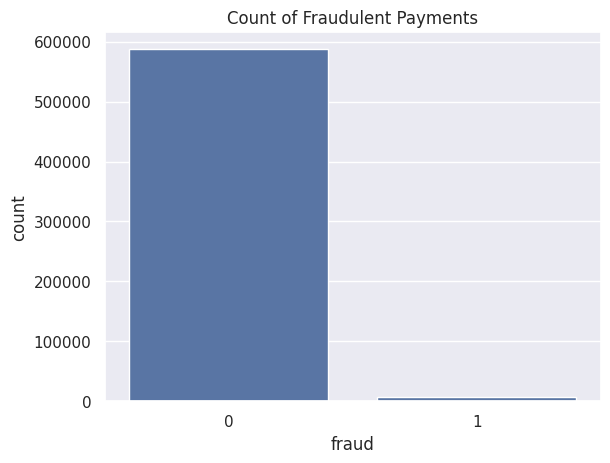

Number of normal examples:  587443
Number of fradulent examples:  7200


In [ ]:
# Create two dataframes with fraud and non-fraud data
df_fraud = data.loc[data.fraud == 1]
df_non_fraud = data.loc[data.fraud == 0]

sns.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",df_non_fraud.fraud.count())
print("Number of fradulent examples: ",df_fraud.fraud.count())

In [ ]:
print("Mean feature values per category", data.groupby('category')[['amount', 'fraud']].mean())

Mean feature values per category                               amount     fraud
category                                      
'es_barsandrestaurants'    43.461014  0.018829
'es_contents'              44.547571  0.000000
'es_fashion'               65.666642  0.017973
'es_food'                  37.070405  0.000000
'es_health'               135.621367  0.105126
'es_home'                 165.670846  0.152064
'es_hotelservices'        205.614249  0.314220
'es_hyper'                 45.970421  0.045917
'es_leisure'              288.911303  0.949900
'es_otherservices'        135.881524  0.250000
'es_sportsandtoys'        215.715280  0.495252
'es_tech'                 120.947937  0.066667
'es_transportation'        26.958187  0.000000
'es_travel'              2250.409190  0.793956
'es_wellnessandbeauty'     65.511221  0.047594


In [ ]:
# Create two dataframes with fraud and non-fraud data
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           data.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

Fraudulent  Non-Fraudulent  Percent(%)
category                                                        
'es_transportation'              NaN       26.958187    0.000000
'es_food'                        NaN       37.070405    0.000000
'es_hyper'                169.255429       40.037145    4.591669
'es_barsandrestaurants'   164.092667       41.145997    1.882944
'es_contents'                    NaN       44.547571    0.000000
'es_wellnessandbeauty'    229.422535       57.320219    4.759380
'es_fashion'              247.008190       62.347674    1.797335
'es_leisure'              300.286878       73.230400   94.989980
'es_otherservices'        316.469605       75.685497   25.000000
'es_sportsandtoys'        345.366811       88.502738   49.525237
'es_tech'                 415.274114       99.924638    6.666667
'es_health'               407.031338      103.737228   10.512614
'es_hotelservices'        421.823339      106.548545   31.422018
'es_home'                 457.484834      113.338409   15.206445
'es_travel'              2660.802872      669.025533   79.395604

<ipython-input-8-3b3cb4c1be11>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data.category, y=data.amount, palette="Set2")  # You can change 'Set2' to any other palette like 'Set3', 'Paired', 'rainbow', etc.


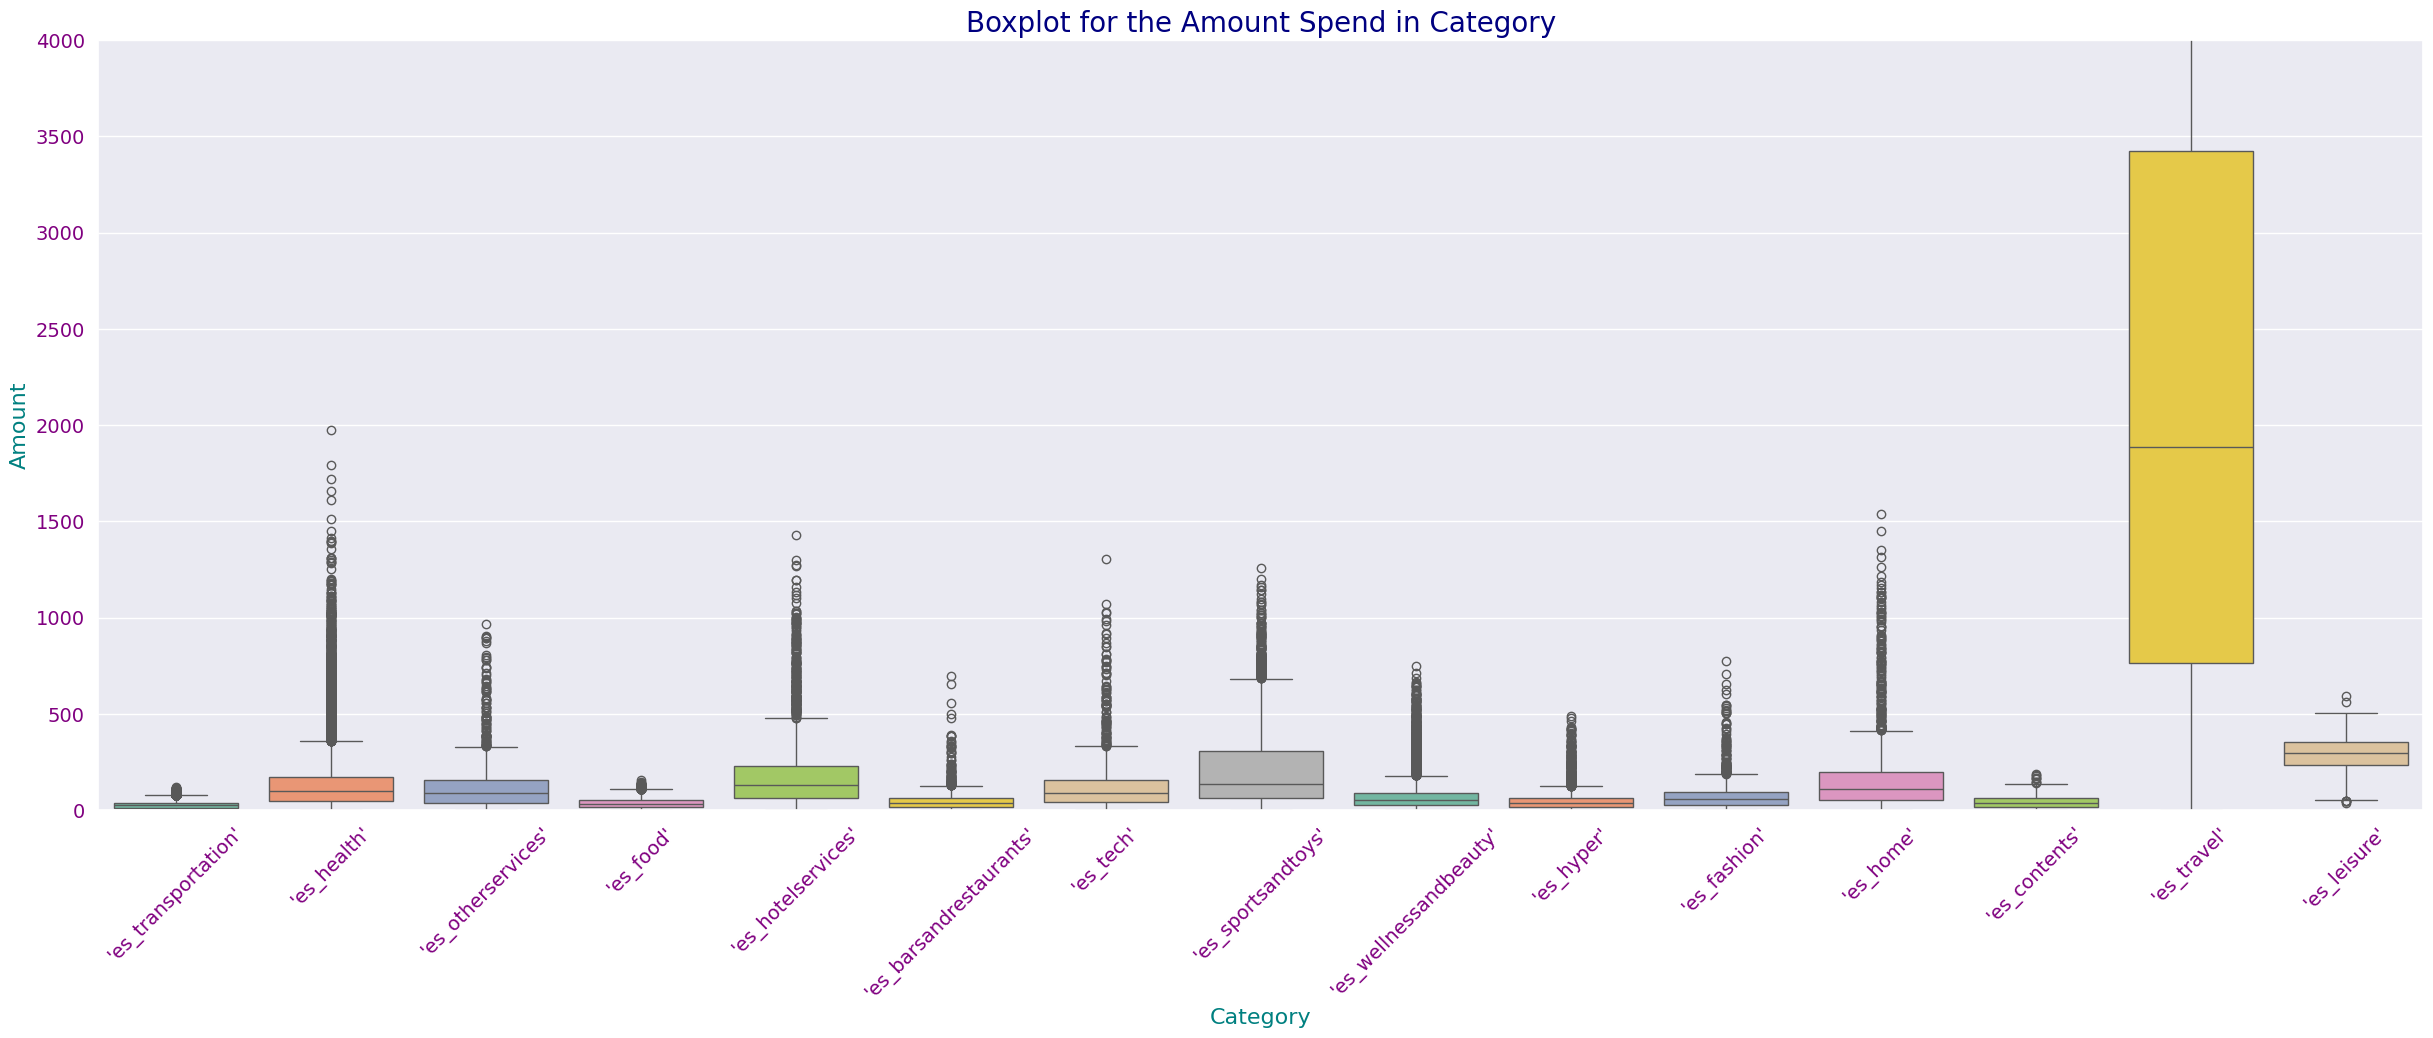

In [ ]:
plt.figure(figsize=(30, 10))
sns.boxplot(x=data.category, y=data.amount, palette="Set2")  # You can change 'Set2' to any other palette like 'Set3', 'Paired', 'rainbow', etc.
plt.title("Boxplot for the Amount Spend in Category", fontsize=20, color='navy')
plt.ylim(0, 4000)
plt.xticks(rotation=45, fontsize=14, color='purple')
plt.yticks(fontsize=14, color='purple')
plt.xlabel('Category', fontsize=16, color='teal')
plt.ylabel('Amount', fontsize=16, color='teal')
plt.show()

In [ ]:
print((data.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.594228
6  '6'       0.974826
5  '5'       1.095112
1  '1'       1.185254
3  '3'       1.192815
2  '2'       1.251401
4  '4'       1.293281
0  '0'       1.957586


In [ ]:
print("Unique zipCodeOri values: ",data.zipcodeOri.nunique())
print("Unique zipMerchant values: ",data.zipMerchant.nunique())
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


In [ ]:
data_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

In [ ]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')

data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

step  customer  age  gender  merchant  category  amount  fraud
0     0       210    4       2        30        12    4.55      0
1     0      2753    2       2        30        12   39.68      0
2     0      2285    4       1        18        12   26.89      0
3     0      1650    3       2        30        12   17.25      0
4     0      3585    5       2        30        12   35.72      0

In [ ]:
X = data_reduced.drop(['fraud'],axis=1)
y = data['fraud']

print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


In [ ]:
data_reduced["category"].nunique

<bound method IndexOpsMixin.nunique of 0         12
1         12
2         12
3         12
4         12
          ..
594638    12
594639    12
594640     2
594641    12
594642    12
Name: category, Length: 594643, dtype: int8>

In [ ]:
y[y==1].count()

7200

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

## **Neural Network**

**ADAM**

In [ ]:
import tensorflow as tf
import numpy as np

input_dim = X_train.shape[1]
output_dim = 1
hidden_units = [64, 32]

# Build the feedforward neural network model
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(input_dim,)))

for units in hidden_units:
    model.add(tf.keras.layers.Dense(units, activation='relu'))

model.add(tf.keras.layers.Dense(output_dim, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,625 (10.25 KB)

 Trainable params: 2,625 (10.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=10,
    callbacks=[early_stopping],
)


Epoch 1/10
1607/1607 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8542 - loss: 2.8385 - val_accuracy: 0.9053 - val_loss: 0.7620
Epoch 2/10
1607/1607 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8961 - loss: 0.4759 - val_accuracy: 0.9189 - val_loss: 0.2703
Epoch 3/10
1607/1607 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8969 - loss: 0.4329 - val_accuracy: 0.7769 - val_loss: 0.8927
Epoch 4/10
1607/1607 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9027 - loss: 0.3652 - val_accuracy: 0.9144 - val_loss: 0.2643
Epoch 5/10
1607/1607 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8992 - loss: 0.3750 - val_accuracy: 0.9199 - val_loss: 0.2070
Epoch 6/10
1607/1607 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9037 - loss: 0.3320 - val_accuracy: 0.9223 - val_loss: 0.1962
Epoch 7/10
1607/1607 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9078 - loss: 0.2933 - val_accuracy: 0.9110 - val_loss: 0.2545
Epoch 8/10
1607/1607 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9147 - loss: 0.2463 - 

**RandomForest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("Classification Report for Random Forest:\n", classification_report(y_test, rf_predictions))


Random Forest Accuracy: 0.9960368400105385
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    176277
           1       0.90      0.75      0.82      2116

    accuracy                           1.00    178393
   macro avg       0.95      0.88      0.91    178393
weighted avg       1.00      1.00      1.00    178393



**xgboost**

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))
print("Classification Report for XGBoost:\n", classification_report(y_test, xgb_predictions))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9964404432909363
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    176277
           1       0.89      0.80      0.84      2116

    accuracy                           1.00    178393
   macro avg       0.94      0.90      0.92    178393
weighted avg       1.00      1.00      1.00    178393



In [ ]:
import matplotlib.pyplot as plt

# Model names and accuracies
models = ['ADAM', 'Random Forest', 'XGBoost']
accuracies = [0.9445, 0.9960368400105385, 0.9964404432909363]

# Plotting a bar chart
fig, ax = plt.subplots(figsize=(8, 6))

# Create the bar chart
bars = ax.bar(models, accuracies, color=['blue', 'green', 'orange'])

# Add labels and title
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title('Model Accuracy Comparison', fontsize=16)

# Display accuracy values on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Show the plot
plt.show()


In [ ]:
X.head(593930)

step  customer  age  gender  merchant  category  amount
0          0       210    4       2        30        12    4.55
1          0      2753    2       2        30        12   39.68
2          0      2285    4       1        18        12   26.89
3          0      1650    3       2        30        12   17.25
4          0      3585    5       2        30        12   35.72
...      ...       ...  ...     ...       ...       ...     ...
593925   179      2431    5       1        30        12   18.87
593926   179      4043    4       2        18        12   13.73
593927   179       769    5       1        32         8  308.82
593928   179      2456    5       2        32         8  192.78
593929   179      3916    2       1        18        12   26.23

[593930 rows x 7 columns]

In [ ]:
y.head(593930)

0         0
1         0
2         0
3         0
4         0
         ..
593925    0
593926    0
593927    1
593928    1
593929    0
Name: fraud, Length: 593930, dtype: int64

In [ ]:
import numpy as np
import pandas as pd
sample_input = np.array([[0,2753,2,2,30,12,39.68]])

xgb_prediction = xgb_model.predict(sample_input)

print("XGBoost Prediction for the sample input:", xgb_prediction)


XGBoost Prediction for the sample input: [0]


In [ ]:
import numpy as np
import pandas as pd
sample_input = np.array([[179,2456,5,2,32,8,192.78]])

xgb_prediction = xgb_model.predict(sample_input)

print("XGBoost Prediction for the sample input:", xgb_prediction)

XGBoost Prediction for the sample input: [1]


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Assuming your XGBClassifier model is already trained:
# xgb_model.fit(X_train, y_train)

# Function to get input from the user and predict using the trained XGBoost model
def get_user_input_and_predict():
    try:
        # Get user input for each feature
        step=int(input("Enter step: "))
        customer = int(input("Enter customer ID (numeric value): "))
        age = int(input("Enter age (numeric value): "))
        gender = int(input("Enter gender (1 for female, 2 for male): "))
        merchant = int(input("Enter merchant ID (numeric value): "))
        category = int(input("Enter category (numeric value): "))
        amount = float(input("Enter amount (numeric value): "))

        # Combine input into an array (2D array with one row, matching model's input format)
        user_input = np.array([[step,customer, age, gender, merchant, category, amount]])

        # Predict using the trained model
        prediction = xgb_model.predict(user_input)

        # Output the prediction
        print("\nXGBoost Prediction for the given input:", prediction[0])

    except ValueError as e:
        print("Invalid input. Please enter the correct numeric values.")

# Call the function to get input and predict
get_user_input_and_predict()


Enter step: 1
Enter customer ID (numeric value): 1586
Enter age (numeric value): 6
Enter gender (1 for female, 2 for male): 1
Enter merchant ID (numeric value): 55
Enter category (numeric value): 55
Enter amount (numeric value): 15879

XGBoost Prediction for the given input: 1
